importing require libraries

In [ ]:
import numpy as np
import pandas as pd
import matplotlib as plt

reading datasets and some info about it

In [ ]:
train = pd.read_csv('/content/train.csv',index_col = 'Id')
test = pd.read_csv('/content/test.csv',index_col = 'Id')
sample = pd.read_csv('/content/sample_submission.csv')
display(train.head())
x_train = train.iloc[:,:-1]
y_train = train.iloc[:,-1:]
train.info()

,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
Id,,,,,,,,,,,,,,,,,,,,,
1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,Inside,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,FR2,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,Inside,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,Corner,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,FR2,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


<class 'pandas.core.frame.DataFrame'>
Index: 1460 entries, 1 to 1460
Data columns (total 80 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   MSSubClass     1460 non-null   int64  
 1   MSZoning       1460 non-null   object 
 2   LotFrontage    1201 non-null   float64
 3   LotArea        1460 non-null   int64  
 4   Street         1460 non-null   object 
 5   Alley          91 non-null     object 
 6   LotShape       1460 non-null   object 
 7   LandContour    1460 non-null   object 
 8   Utilities      1460 non-null   object 
 9   LotConfig      1460 non-null   object 
 10  LandSlope      1460 non-null   object 
 11  Neighborhood   1460 non-null   object 
 12  Condition1     1460 non-null   object 
 13  Condition2     1460 non-null   object 
 14  BldgType       1460 non-null   object 
 15  HouseStyle     1460 non-null   object 
 16  OverallQual    1460 non-null   int64  
 17  OverallCond    1460 non-null   int64  
 18  YearBuilt    

##data prepration

doing some elimination on dataset

In [ ]:
categorical_cols = [cols for cols in x_train.columns if x_train[cols].dtypes == 'object']
numerical_cols = [cols for cols in x_train.columns if x_train[cols].dtypes in ['int64','float64']]
high_cardi = list(x_train[categorical_cols].loc[:,x_train[categorical_cols].nunique()>10].columns)
missing = x_train.isna().sum()[x_train.isna().sum()>0]
high_missing = list(missing[missing>1000].index)
categ_no_high_missing = [cols for cols in categorical_cols if cols  not in high_missing]
print(f'in our dataset the high cardinality features are:\n{high_cardi}\n\
and we have columns with more tham 1000 missing values are:\n{high_missing}')


in our dataset the high cardinality features are:
['Neighborhood', 'Exterior1st', 'Exterior2nd']
and we have columns with more tham 1000 missing values are:
['Alley', 'PoolQC', 'Fence', 'MiscFeature']


missing value imputation

In [ ]:
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import FunctionTransformer
def nam_col(x):
  return (pd.DataFrame(x,columns = numerical_cols+high_missing+categ_no_high_missing))
Imputer = ColumnTransformer([
    ('numerical',SimpleImputer(strategy='mean'),numerical_cols),
    ('high missing', SimpleImputer(strategy = 'constant'),high_missing),
    ('categorical',SimpleImputer(strategy = 'most_frequent'),categ_no_high_missing)
])
convert_to_df = FunctionTransformer(nam_col)
pipe_impute = Pipeline(steps = [
    ('imputer',Imputer),
    ('naming',convert_to_df)
])
imputed_x_train = pipe_impute.fit_transform(x_train)
imputed_x_train

,MSSubClass,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,BsmtFinSF2,...,KitchenQual,Functional,FireplaceQu,GarageType,GarageFinish,GarageQual,GarageCond,PavedDrive,SaleType,SaleCondition
0,60.0,65.0,8450.0,7.0,5.0,2003.0,2003.0,196.0,706.0,0.0,...,Gd,Typ,Gd,Attchd,RFn,TA,TA,Y,WD,Normal
1,20.0,80.0,9600.0,6.0,8.0,1976.0,1976.0,0.0,978.0,0.0,...,TA,Typ,TA,Attchd,RFn,TA,TA,Y,WD,Normal
2,60.0,68.0,11250.0,7.0,5.0,2001.0,2002.0,162.0,486.0,0.0,...,Gd,Typ,TA,Attchd,RFn,TA,TA,Y,WD,Normal
3,70.0,60.0,9550.0,7.0,5.0,1915.0,1970.0,0.0,216.0,0.0,...,Gd,Typ,Gd,Detchd,Unf,TA,TA,Y,WD,Abnorml
4,60.0,84.0,14260.0,8.0,5.0,2000.0,2000.0,350.0,655.0,0.0,...,Gd,Typ,TA,Attchd,RFn,TA,TA,Y,WD,Normal
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1455,60.0,62.0,7917.0,6.0,5.0,1999.0,2000.0,0.0,0.0,0.0,...,TA,Typ,TA,Attchd,RFn,TA,TA,Y,WD,Normal
1456,20.0,85.0,13175.0,6.0,6.0,1978.0,1988.0,119.0,790.0,163.0,...,TA,Min1,TA,Attchd,Unf,TA,TA,Y,WD,Normal
1457,70.0,66.0,9042.0,7.0,9.0,1941.0,2006.0,0.0,275.0,0.0,...,Gd,Typ,Gd,Attchd,RFn,TA,TA,Y,WD,Normal
1458,20.0,68.0,9717.0,5.0,6.0,1950.0,1996.0,0.0,49.0,1029.0,...,Gd,Typ,Gd,Attchd,Unf,TA,TA,Y,WD,Normal


ordinal encoding

In [ ]:
from sklearn.preprocessing import OrdinalEncoder
ordinal =ColumnTransformer( [
    ('nothing','passthrough',numerical_cols),
    ('ordinal_high_misssing' , OrdinalEncoder(),high_missing),
    ('ordinal_categ',OrdinalEncoder(),categ_no_high_missing)
])

pipe_ordinal = Pipeline(steps = [
    ('impute', pipe_impute),
    ('ordinal',ordinal),
    ('naming',convert_to_df)
])
ordinal_x_train = pipe_ordinal.fit_transform(x_train)
ordinal_x_train = ordinal_x_train.astype('float64')
ordinal_x_train

,MSSubClass,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,BsmtFinSF2,...,KitchenQual,Functional,FireplaceQu,GarageType,GarageFinish,GarageQual,GarageCond,PavedDrive,SaleType,SaleCondition
0,60.0,65.0,8450.0,7.0,5.0,2003.0,2003.0,196.0,706.0,0.0,...,2.0,6.0,2.0,1.0,1.0,4.0,4.0,2.0,8.0,4.0
1,20.0,80.0,9600.0,6.0,8.0,1976.0,1976.0,0.0,978.0,0.0,...,3.0,6.0,4.0,1.0,1.0,4.0,4.0,2.0,8.0,4.0
2,60.0,68.0,11250.0,7.0,5.0,2001.0,2002.0,162.0,486.0,0.0,...,2.0,6.0,4.0,1.0,1.0,4.0,4.0,2.0,8.0,4.0
3,70.0,60.0,9550.0,7.0,5.0,1915.0,1970.0,0.0,216.0,0.0,...,2.0,6.0,2.0,5.0,2.0,4.0,4.0,2.0,8.0,0.0
4,60.0,84.0,14260.0,8.0,5.0,2000.0,2000.0,350.0,655.0,0.0,...,2.0,6.0,4.0,1.0,1.0,4.0,4.0,2.0,8.0,4.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1455,60.0,62.0,7917.0,6.0,5.0,1999.0,2000.0,0.0,0.0,0.0,...,3.0,6.0,4.0,1.0,1.0,4.0,4.0,2.0,8.0,4.0
1456,20.0,85.0,13175.0,6.0,6.0,1978.0,1988.0,119.0,790.0,163.0,...,3.0,2.0,4.0,1.0,2.0,4.0,4.0,2.0,8.0,4.0
1457,70.0,66.0,9042.0,7.0,9.0,1941.0,2006.0,0.0,275.0,0.0,...,2.0,6.0,2.0,1.0,1.0,4.0,4.0,2.0,8.0,4.0
1458,20.0,68.0,9717.0,5.0,6.0,1950.0,1996.0,0.0,49.0,1029.0,...,2.0,6.0,2.0,1.0,2.0,4.0,4.0,2.0,8.0,4.0


one hot encoding

In [ ]:
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import StandardScaler
onehot = OneHotEncoder(handle_unknown = 'ignore',sparse_output = False)
onehot_trans = ColumnTransformer([('one hot', onehot , categorical_cols)],
                                 remainder = 'passthrough')
onehot_trans.set_output(transform = 'pandas')

onehot_norm_pipe = Pipeline([('onehot',onehot_trans),
                             ('normalize' , StandardScaler())])
onehot_norm_pipe.set_output(transform = 'pandas')
hot_norm_x = onehot_norm_pipe.fit_transform(imputed_x_train)
hot_norm_x


,one hot__MSZoning_C (all),one hot__MSZoning_FV,one hot__MSZoning_RH,one hot__MSZoning_RL,one hot__MSZoning_RM,one hot__Street_Grvl,one hot__Street_Pave,one hot__Alley_Grvl,one hot__Alley_Pave,one hot__Alley_missing_value,...,remainder__GarageArea,remainder__WoodDeckSF,remainder__OpenPorchSF,remainder__EnclosedPorch,remainder__3SsnPorch,remainder__ScreenPorch,remainder__PoolArea,remainder__MiscVal,remainder__MoSold,remainder__YrSold
0,-0.083045,-0.215859,-0.105263,0.518133,-0.418955,-0.064238,0.064238,-0.188311,-0.169981,0.257821,...,0.351000,-0.752176,0.216503,-0.359325,-0.116339,-0.270208,-0.068692,-0.087688,-1.599111,0.138777
1,-0.083045,-0.215859,-0.105263,0.518133,-0.418955,-0.064238,0.064238,-0.188311,-0.169981,0.257821,...,-0.060731,1.626195,-0.704483,-0.359325,-0.116339,-0.270208,-0.068692,-0.087688,-0.489110,-0.614439
2,-0.083045,-0.215859,-0.105263,0.518133,-0.418955,-0.064238,0.064238,-0.188311,-0.169981,0.257821,...,0.631726,-0.752176,-0.070361,-0.359325,-0.116339,-0.270208,-0.068692,-0.087688,0.990891,0.138777
3,-0.083045,-0.215859,-0.105263,0.518133,-0.418955,-0.064238,0.064238,-0.188311,-0.169981,0.257821,...,0.790804,-0.752176,-0.176048,4.092524,-0.116339,-0.270208,-0.068692,-0.087688,-1.599111,-1.367655
4,-0.083045,-0.215859,-0.105263,0.518133,-0.418955,-0.064238,0.064238,-0.188311,-0.169981,0.257821,...,1.698485,0.780197,0.563760,-0.359325,-0.116339,-0.270208,-0.068692,-0.087688,2.100892,0.138777
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1455,-0.083045,-0.215859,-0.105263,0.518133,-0.418955,-0.064238,0.064238,-0.188311,-0.169981,0.257821,...,-0.060731,-0.752176,-0.100558,-0.359325,-0.116339,-0.270208,-0.068692,-0.087688,0.620891,-0.614439
1456,-0.083045,-0.215859,-0.105263,0.518133,-0.418955,-0.064238,0.064238,-0.188311,-0.169981,0.257821,...,0.126420,2.033231,-0.704483,-0.359325,-0.116339,-0.270208,-0.068692,-0.087688,-1.599111,1.645210
1457,-0.083045,-0.215859,-0.105263,0.518133,-0.418955,-0.064238,0.064238,-0.188311,-0.169981,0.257821,...,-1.033914,-0.752176,0.201405,-0.359325,-0.116339,-0.270208,-0.068692,4.953112,-0.489110,1.645210
1458,-0.083045,-0.215859,-0.105263,0.518133,-0.418955,-0.064238,0.064238,-0.188311,-0.169981,0.257821,...,-1.090059,2.168910,-0.704483,1.473789,-0.116339,-0.270208,-0.068692,-0.087688,-0.859110,1.645210


##finding most effective features

with SelectKBest of scikit learn

In [ ]:
from sklearn.feature_selection import SelectKBest, f_regression , mutual_info_regression

In [ ]:
best_fea = SelectKBest(mutual_info_regression)
fitted_bestf = best_fea.fit(ordinal_x_train,np.array(y_train).reshape(-1,))
df_scores = pd.DataFrame(ordinal_x_train.columns,columns = ['features'])
df_scores['scores'] = fitted_bestf.scores_
best_ordinal_features = df_scores.nlargest(160,'scores')
print('with ordinal encoder best features are:')
display(df_scores.nlargest(20,'scores'))
print(f'categorical cols in above features are:{[col for col in df_scores.nlargest(20,"scores").features if col in categorical_cols]}\n\n')
fitted_bestf2 = best_fea.fit(hot_norm_x,np.array(y_train).reshape(-1,))
df2_scores = pd.DataFrame(hot_norm_x.columns,columns = ['features'])
df2_scores['scores'] = fitted_bestf.scores_
print('with one hot encoder best features are:')
best_onehot_features = df2_scores.nlargest(60,'scores')
display(best_onehot_features[:20])


with ordinal encoder best features are:


,features,scores
3,OverallQual,0.573505
47,Neighborhood,0.511778
15,GrLivArea,0.484596
11,TotalBsmtSF,0.366144
5,YearBuilt,0.366032
25,GarageCars,0.364528
26,GarageArea,0.356177
69,KitchenQual,0.338387
57,ExterQual,0.329927
60,BsmtQual,0.321785


categorical cols in above features are:['Neighborhood', 'KitchenQual', 'ExterQual', 'BsmtQual', 'GarageFinish', 'Foundation']


with one hot encoder best features are:


,features,scores
258,remainder__OverallQual,0.572713
270,remainder__GrLivArea,0.484392
260,remainder__YearBuilt,0.367625
281,remainder__GarageArea,0.367137
266,remainder__TotalBsmtSF,0.365240
280,remainder__GarageCars,0.360061
267,remainder__1stFlrSF,0.308654
279,remainder__GarageYrBlt,0.290850
134,one hot__ExterQual_TA,0.275387
255,remainder__MSSubClass,0.272377


**finding best features with corellations:**

with 80 features that comes from best features with SelectKBest tool of scikit learn we form correlation matrics


In [ ]:
import seaborn as sns
from matplotlib import pyplot as plt

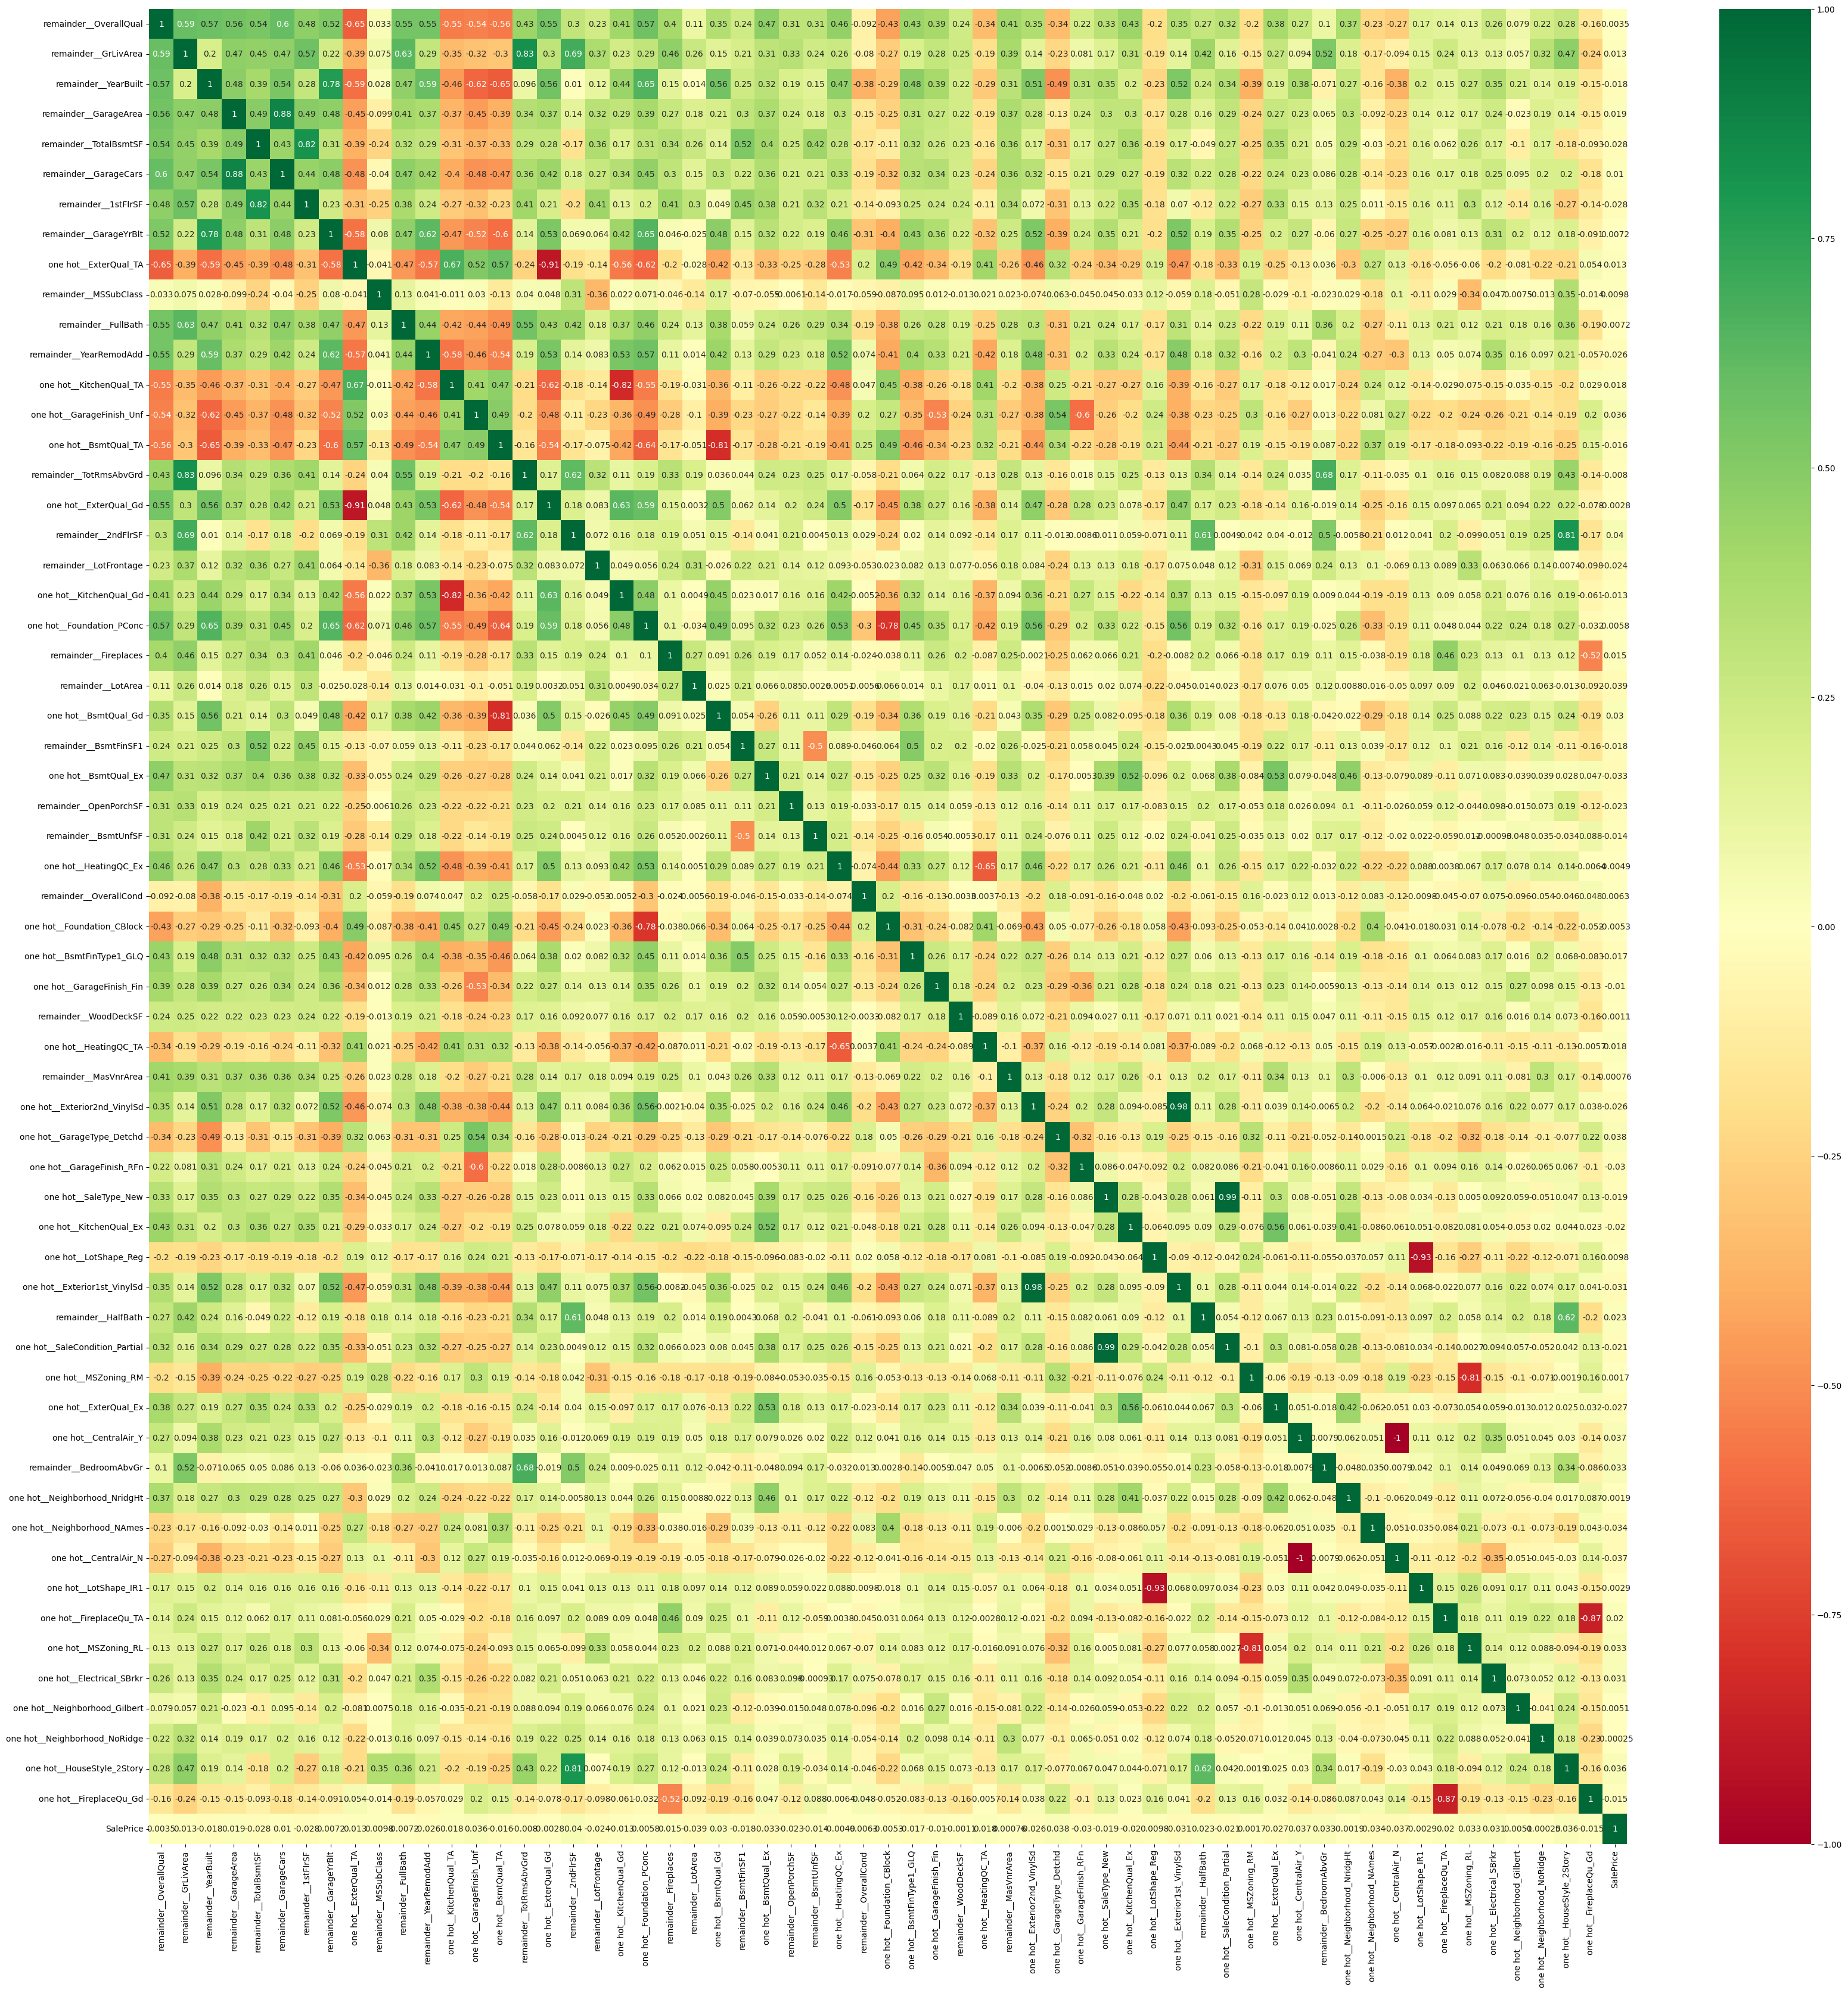

with correlation map best features are that having distance from 0 so we caculate absolute value for finding best features so we have: remainder__2ndFlrSF             0.040336
remainder__LotArea              0.038772
one hot__GarageType_Detchd      0.038162
one hot__CentralAir_Y           0.036982
one hot__CentralAir_N           0.036982
one hot__HouseStyle_2Story      0.035989
one hot__GarageFinish_Unf       0.035959
one hot__Neighborhood_NAmes     0.034181
one hot__MSZoning_RL            0.033399
remainder__BedroomAbvGr         0.032640
one hot__BsmtQual_Ex            0.032573
one hot__Electrical_SBrkr       0.031285
one hot__Exterior1st_VinylSd    0.031253
one hot__GarageFinish_RFn       0.030113
one hot__BsmtQual_Gd            0.030047
remainder__TotalBsmtSF          0.028064
remainder__1stFlrSF             0.027657
one hot__ExterQual_Ex           0.026855
remainder__YearRemodAdd         0.026340
one hot__Exterior2nd_VinylSd    0.025926
Name: SalePrice, dtype: float64


In [ ]:
corr_df = pd.concat([hot_norm_x[best_onehot_features.features],y_train],axis = 1)
cor_mat = corr_df.corr()
plt.figure(figsize=(40,40))
sns.heatmap(cor_mat,annot=True,cmap="RdYlGn")
plt.show()
best_correlated_features = abs(cor_mat.SalePrice).nlargest(21).drop('SalePrice')
print(f'with correlation map best features are that having distance from 0 so \
we caculate absolute value for finding best features so we have: {best_correlated_features}')

with correlation map best features are that having distance from 0 so
we caculate absolute value for finding best features

visualizing some datas and trend lines

###visualize some trends on best features selected by SelectKBest

In [ ]:
from sklearn.linear_model import LinearRegression
for i in range(20):
  globals()['linear_regr'+str(i)] = LinearRegression()
  globals()['linear_regr'+str(i)].fit(hot_norm_x[[best_onehot_features.features.iloc[i]]],y_train)


for 10 first feture selected based on method SelectKBest with matual info regression score function
we fit a linear regression task and slope of this line can show importancy of that feature if we can use only that one. 


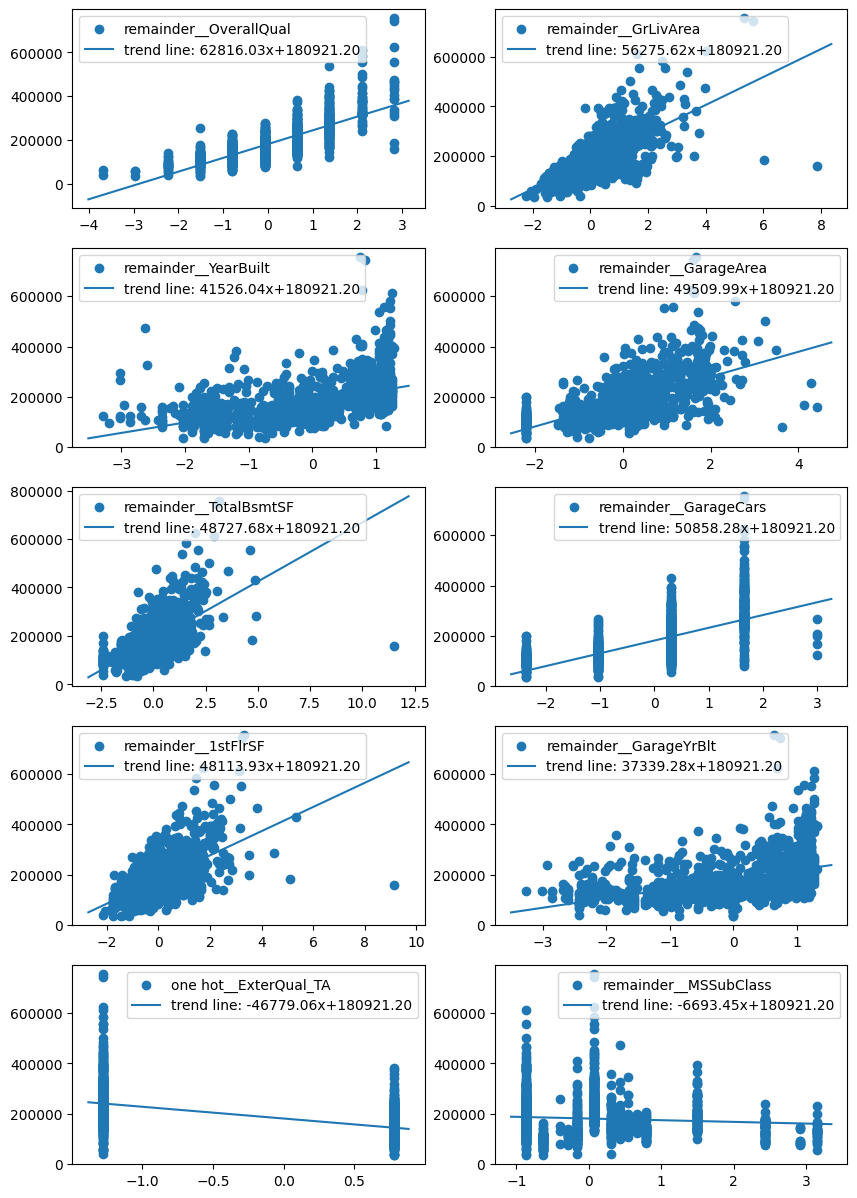

In [ ]:
plt.figure(figsize=(10,15))
print('for 10 first feture selected based on method SelectKBest with matual info regression score function\n\
we fit a linear regression task and slope of this line can show importancy of that feature if we can use only that one. ')
for i in range(10):
  weight = globals()['linear_regr'+str(i)].coef_[0,0]
  bias = globals()['linear_regr'+str(i)].intercept_[0]
  plt.subplot(5,2,i+1)
  plt.scatter(x = hot_norm_x[best_onehot_features.features.iloc[i]], y = y_train)
  x_lin = np.linspace(plt.xlim()[0],plt.xlim()[1],100)
  plt.plot(x_lin , x_lin*weight + bias)
  plt.legend([best_onehot_features.features.iloc[i],f'trend line: {weight:.2f}x+{bias:.2f}'])

finding which combination of our features based on SelectKBest method(both ordinal and onehot normalized datasets) and correlated method is more convinient

selecting which method to find best features was better

In [ ]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import cross_validate
from sklearn.metrics import mean_squared_error

In [ ]:
features_selected = {'one_hot':[hot_norm_x , best_onehot_features.features[:20]],'ordinal' : [ordinal_x_train, best_ordinal_features.features[:20]]\
                     ,'correlated' : [hot_norm_x , best_correlated_features.index]}
scores_dic = {}
for key , [data, features] in features_selected.items():
  random_forest = RandomForestRegressor(criterion = "squared_error")
  scores_dic[key] = cross_validate(random_forest , data[features] , np.reshape(y_train,(len(y_train),)) \
                        ,scoring = 'neg_mean_absolute_error',return_train_score= True)
  print(f'for 20 features selected based on {key} method the results for training is: {scores_dic[key]["train_score"].mean()} \
  and for validation is: {scores_dic[key]["test_score"].mean()} ')


for 20 features selected based on one_hot method the results for training is: -7319.422676546531   and for validation is: -19653.677228256143 
for 20 features selected based on ordinal method the results for training is: -7136.9664013780175   and for validation is: -19063.406541476408 
for 20 features selected based on correlated method the results for training is: -7949.046901258426   and for validation is: -21040.7609244401 


now that we found best feature for us is ordinal encoding we want to know how many features we should use

## investigating model and hyperparameters tuning

In [ ]:
for i in range(1,7):
  scores = cross_validate(random_forest,ordinal_x_train[best_ordinal_features.features[:i*20]],np.reshape(y_train,(len(y_train,))),\
                          scoring = 'neg_mean_absolute_error' , return_train_score = True)
  print(f'negetive mean absolute error for ordinal dataset with {(i)*20} features  in training is : {scores["train_score"].mean()}\n\
   and validation error is :{scores["test_score"].mean()} with fitting time: {scores["fit_time"].mean()} ')

negetive mean absolute error for ordinal dataset with 20 features  in training is : -7141.966349502856
   and validation error is :-18933.188430646976 with fitting time: 1.6644132137298584 
negetive mean absolute error for ordinal dataset with 40 features  in training is : -6577.34390981735
   and validation error is :-17531.411509132417 with fitting time: 1.6474324703216552 
negetive mean absolute error for ordinal dataset with 60 features  in training is : -6538.844528375734
   and validation error is :-17390.47333953033 with fitting time: 1.8725904464721679 
negetive mean absolute error for ordinal dataset with 80 features  in training is : -6645.121342465753
   and validation error is :-17530.934417808217 with fitting time: 2.1010913848876953 
negetive mean absolute error for ordinal dataset with 100 features  in training is : -6584.977061643835
   and validation error is :-17690.174527397256 with fitting time: 1.9756736278533935 
negetive mean absolute error for ordinal dataset wi

now we know that optimize number of best features is 60.
for next level we examine another tree based model , xgBoost regressor


In [ ]:
from xgboost import XGBRegressor
xg = XGBRegressor()

In [ ]:
xg_cross = cross_validate(xg,ordinal_x_train[best_ordinal_features.features[:60]] , np.reshape(y_train,(len(y_train),)) \
                        ,scoring = 'neg_mean_absolute_error',return_train_score= True)
print(f'negetive mean absolute error for ordinal dataset with 60 features  in training is : {xg_cross["train_score"].mean()}\n\
  and validation error is :{xg_cross["test_score"].mean()} with fitting time: {xg_cross["fit_time"].mean()} ')

negetive mean absolute error for ordinal dataset with 60 features  in training is : -693.1226241438357
  and validation error is :-17386.50867936644 with fitting time: 0.4284983158111572 


with comparing results we choose to have hyperparameters tuning with both random forest and xgboost regression . also we experience somehow a big distance between train and test scores so we also want to find best parameters for validation score and also solve overfitting

### grid search for finding best parametr

In [ ]:
from sklearn.model_selection import GridSearchCV

In [ ]:
grid_parameters = {'min_samples_split':[2,4,8,16], 'n_estimators': [50,100,150,200]}
gridsearch_forrest = GridSearchCV(random_forest ,param_grid = grid_parameters,scoring = 'neg_mean_absolute_error',return_train_score = True)
gridsearch_forrest.fit(ordinal_x_train[best_ordinal_features.features[:60]],np.reshape(y_train,(len(y_train),)))

GridSearchCV(estimator=RandomForestRegressor(),
             param_grid={'min_samples_split': [2, 4, 8, 16],
                         'n_estimators': [50, 100, 150, 200]},
             return_train_score=True, scoring='neg_mean_absolute_error')

In [ ]:
print(f'best parameters are: {gridsearch_forrest.best_params_}')
index_best_param = gridsearch_forrest.cv_results_['params'].index(gridsearch_forrest.best_params_)
train_score_best = gridsearch_forrest.cv_results_['mean_train_score'][index_best_param]
test_score_best = gridsearch_forrest.cv_results_['mean_test_score'][index_best_param]
print(f'for best parameter mean train score is :{train_score_best} and test score is :{test_score_best}')

best parameters are: {'min_samples_split': 2, 'n_estimators': 200}
for best parameter mean train score is :-6440.711705234835 and test score is :-17361.89510909981


we continue for parameters tuning with grid search for xgboost

In [ ]:

from sklearn.model_selection import GridSearchCV
xgb_parameters = {'n_estimators': [120,200,250,600],'max_depth':[2,3,5],'learning_rate': [0.01,0.05,0.1],'min_child_weight':[0.1,0.5,1]}
gridsearch_xgb = GridSearchCV(xg ,param_grid = xgb_parameters,scoring = 'neg_mean_absolute_error',return_train_score = True)
gridsearch_xgb.fit(ordinal_x_train[best_ordinal_features.features[:60]],np.reshape(y_train,(len(y_train),)))

GridSearchCV(estimator=XGBRegressor(base_score=None, booster=None,
                                    callbacks=None, colsample_bylevel=None,
                                    colsample_bynode=None,
                                    colsample_bytree=None, device=None,
                                    early_stopping_rounds=None,
                                    enable_categorical=False, eval_metric=None,
                                    feature_types=None, gamma=None,
                                    grow_policy=None, importance_type=None,
                                    interaction_constraints=None,
                                    learning_rate=None, max_bi...
                                    max_depth=None, max_leaves=None,
                                    min_child_weight=None, missing=nan,
                                    monotone_constraints=None,
                                    multi_strategy=None, n_estimators=None,
                                    n_jobs=None, num_parallel_tree=None,
                                    random_state=None, ...),
             param_grid={'learning_rate': [0.01, 0.05, 0.1],
                         'max_depth': [2, 3, 5],
                         'min_child_weight': [0.1, 0.5, 1],
                         'n_estimators': [120, 200, 250, 600]},
             return_train_score=True, scoring='neg_mean_absolute_error')

In [ ]:
print(f'best parameters are: {gridsearch_xgb.best_params_}')
index_best_param = gridsearch_xgb.cv_results_['params'].index(gridsearch_xgb.best_params_)
train_score_best = gridsearch_xgb.cv_results_['mean_train_score'][index_best_param]
test_score_best = gridsearch_xgb.cv_results_['mean_test_score'][index_best_param]
print(f'for best parameter mean train score is :{train_score_best} and test score is :{test_score_best}')

best parameters are: {'learning_rate': 0.05, 'max_depth': 3, 'min_child_weight': 0.1, 'n_estimators': 600}
for best parameter mean train score is :-6897.240838372217 and test score is :-15320.422966609589


as we can see the best performance with almost a good distance is for xgboost regressor with max depth 2 and 250 estimators. also we can see that distances between train and test score from about 16000 decreses to 8500 in optimize situations.

## neural network

In [ ]:
from sklearn.model_selection import KFold
from tensorflow.keras import Sequential
from keras.layers import Dense
mae = {'train':[],'test':[]}
for tr_index,te_index in KFold().split(ordinal_x_train):
  train_x,train_y = ordinal_x_train.iloc[tr_index,:] , y_train.iloc[te_index,:]
  model = Sequential([Dense(units = 150 , activation = 'relu'),
                    Dense(units = 70 , activation = 'relu'),
                    Dense(units = 50, activation = 'relu'),
                    Dense(units = 50, activation = 'relu'),
                    Dense(units = 1 , activation = 'linear')])
  model.compile(optimizer = 'adam',loss = 'mae')
  result = model.fit(ordinal_x_train[best_ordinal_features.features[:60]].iloc[tr_index],y_train.iloc[tr_index],epochs = 50)
  mae['train'].append(result.history['loss'][-1])
  mae['test'].append(model.evaluate(ordinal_x_train[best_ordinal_features.features[:60]].iloc[te_index],y_train.iloc[te_index]))

Epoch 1/50
37/37 [==============================] - 1s 3ms/step - loss: 170154.2500
Epoch 2/50
37/37 [==============================] - 0s 2ms/step - loss: 72339.1094
Epoch 3/50
37/37 [==============================] - 0s 3ms/step - loss: 48337.7070
Epoch 4/50
37/37 [==============================] - 0s 2ms/step - loss: 41583.9922
Epoch 5/50
37/37 [==============================] - 0s 2ms/step - loss: 36601.2773
Epoch 6/50
37/37 [==============================] - 0s 2ms/step - loss: 33157.6758
Epoch 7/50
37/37 [==============================] - 0s 2ms/step - loss: 30933.4766
Epoch 8/50
37/37 [==============================] - 0s 2ms/step - loss: 29417.5508
Epoch 9/50
37/37 [==============================] - 0s 2ms/step - loss: 28725.4492
Epoch 10/50
37/37 [==============================] - 0s 2ms/step - loss: 28118.7871
Epoch 11/50
37/37 [==============================] - 0s 3ms/step - loss: 30131.6191
Epoch 12/50
37/37 [==============================] - 0s 2ms/step - loss: 28490.7988


In [ ]:
print(f'for our model with {model.summary()} describe above our mae for train set is {np.mean(mae["train"])}\
 and for validation is :{np.mean(mae["test"])}')

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_20 (Dense)            (None, 150)               9150      
                                                                 
 dense_21 (Dense)            (None, 70)                10570     
                                                                 
 dense_22 (Dense)            (None, 50)                3550      
                                                                 
 dense_23 (Dense)            (None, 50)                2550      
                                                                 
 dense_24 (Dense)            (None, 1)                 51        
                                                                 
Total params: 25871 (101.06 KB)
Trainable params: 25871 (101.06 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
for our model wi

##choosing model and predict desired variables

as we see our best results was obtained by xgboost with first 60 effective ordinal train set and with parameters : {'learning_rate': 0.05, 'max_depth': 3, 'min_child_weight': 0.1, 'n_estimators': 600}

In [ ]:
from sklearn.metrics import mean_absolute_error
xg = XGBRegressor(learning_rate= 0.05, max_depth= 3, min_child_weight= 0.1, n_estimators= 600,eval_metric = mean_absolute_error)
xg.fit(ordinal_x_train[best_ordinal_features.features[:60]],y_train,eval_set = [(ordinal_x_train[best_ordinal_features.features[:60]],y_train)])

[0]	validation_0-rmse:76594.89108	validation_0-mean_absolute_error:55273.39062
[1]	validation_0-rmse:73945.59413	validation_0-mean_absolute_error:53248.39062
[2]	validation_0-rmse:71459.36356	validation_0-mean_absolute_error:51338.09375
[3]	validation_0-rmse:69104.63815	validation_0-mean_absolute_error:49516.87500
[4]	validation_0-rmse:66826.66303	validation_0-mean_absolute_error:47800.03125
[5]	validation_0-rmse:64697.42883	validation_0-mean_absolute_error:46183.07812
[6]	validation_0-rmse:62709.95365	validation_0-mean_absolute_error:44688.48438
[7]	validation_0-rmse:60758.15004	validation_0-mean_absolute_error:43163.36328
[8]	validation_0-rmse:58939.19685	validation_0-mean_absolute_error:41791.52344
[9]	validation_0-rmse:57173.17060	validation_0-mean_absolute_error:40414.77344
[10]	validation_0-rmse:55511.97980	validation_0-mean_absolute_error:39124.81641
[11]	validation_0-rmse:53940.96627	validation_0-mean_absolute_error:37930.76953
[12]	validation_0-rmse:52397.84920	validation_0-me

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False,
             eval_metric=<function mean_absolute_error at 0x7fdf344bb1c0>,
             feature_types=None, gamma=None, grow_policy=None,
             importance_type=None, interaction_constraints=None,
             learning_rate=0.05, max_bin=None, max_cat_threshold=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=3,
             max_leaves=None, min_child_weight=0.1, missing=nan,
             monotone_constraints=None, multi_strategy=None, n_estimators=600,
             n_jobs=None, num_parallel_tree=None, random_state=None, ...)

transform test data with pipeline that results in best fitting

In [ ]:
prepared_test = pipe_ordinal.transform(test)
prepared_test = prepared_test[best_ordinal_features.features[:60]].astype('float64')
prepared_test

,OverallQual,Neighborhood,GrLivArea,TotalBsmtSF,YearBuilt,GarageCars,GarageArea,KitchenQual,ExterQual,BsmtQual,...,GarageQual,KitchenAbvGr,LandContour,Alley,ScreenPorch,Functional,Heating,BsmtHalfBath,LotConfig,LowQualFinSF
0,5.0,12.0,896.0,882.0,1961.0,1.0,730.0,3.0,3.0,3.0,...,4.0,1.0,3.0,2.0,120.0,6.0,1.0,0.0,4.0,0.0
1,6.0,12.0,1329.0,1329.0,1958.0,1.0,312.0,2.0,3.0,3.0,...,4.0,1.0,3.0,2.0,0.0,6.0,1.0,0.0,0.0,0.0
2,5.0,8.0,1629.0,928.0,1997.0,2.0,482.0,3.0,3.0,2.0,...,4.0,1.0,3.0,2.0,0.0,6.0,1.0,0.0,4.0,0.0
3,6.0,8.0,1604.0,926.0,1998.0,2.0,470.0,2.0,3.0,3.0,...,4.0,1.0,3.0,2.0,0.0,6.0,1.0,0.0,4.0,0.0
4,8.0,22.0,1280.0,1280.0,1992.0,2.0,506.0,2.0,2.0,2.0,...,4.0,1.0,1.0,2.0,144.0,6.0,1.0,0.0,4.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1454,4.0,10.0,1092.0,546.0,1970.0,0.0,0.0,3.0,3.0,3.0,...,4.0,1.0,3.0,2.0,0.0,6.0,1.0,0.0,4.0,0.0
1455,4.0,10.0,1092.0,546.0,1970.0,1.0,286.0,3.0,3.0,3.0,...,4.0,1.0,3.0,2.0,0.0,6.0,1.0,0.0,4.0,0.0
1456,5.0,11.0,1224.0,1224.0,1960.0,2.0,576.0,3.0,3.0,3.0,...,4.0,1.0,3.0,2.0,0.0,6.0,1.0,0.0,4.0,0.0
1457,5.0,11.0,970.0,912.0,1992.0,0.0,0.0,3.0,3.0,2.0,...,4.0,1.0,3.0,2.0,0.0,6.0,1.0,1.0,4.0,0.0


In [ ]:
pd.Series(xg.predict(prepared_test),name ='SalePrice')


0       122906.960938
1       163056.421875
2       179934.203125
3       187824.609375
4       179354.359375
            ...      
1454     77796.906250
1455     79500.039062
1456    159851.781250
1457    117749.210938
1458    229508.140625
Name: SalePrice, Length: 1459, dtype: float32

In [ ]:
pd.DataFrame(xg.predict(prepared_test),index = test.index)

,0
Id,
1461,122906.960938
1462,163056.421875
1463,179934.203125
1464,187824.609375
1465,179354.359375
...,...
2915,77796.906250
2916,79500.039062
2917,159851.781250


In [ ]:
submission = pd.DataFrame(xg.predict(prepared_test),index = test.index,columns = ['SalePrice'])
submission.to_csv('home_price_submission.csv')
display(submission)

,SalePrice
Id,
1461,122906.960938
1462,163056.421875
1463,179934.203125
1464,187824.609375
1465,179354.359375
...,...
2915,77796.906250
2916,79500.039062
2917,159851.781250


In [ ]:
submission

,Id,SalePrice
0,1461,122906.960938
1,1462,163056.421875
2,1463,179934.203125
3,1464,187824.609375
4,1465,179354.359375
...,...,...
1454,2915,77796.906250
1455,2916,79500.039062
1456,2917,159851.781250
1457,2918,117749.210938


In [ ]:
sample

,Id,SalePrice
0,1461,169277.052498
1,1462,187758.393989
2,1463,183583.683570
3,1464,179317.477511
4,1465,150730.079977
...,...,...
1454,2915,167081.220949
1455,2916,164788.778231
1456,2917,219222.423400
1457,2918,184924.279659
